In [18]:
! pip install -q mne
%load_ext autoreload
%autoreload 2

In [1]:
# Run this notebook outside of main module tree
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
# https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [19]:
from performance import *
from eeg_io import * 

timing = pd.read_csv("../eeg_tests/timing.csv")
eeg_data = "../data/EEG"
pres = "../eeg_tests/logs"

In [ ]:
perf_df = read_all_user_success(timing, eeg_data, pres, targets = ['two-back', 'three-back'])

In [41]:
import re

def design_perf_df(df):
    d = df.copy()
    d = (perf_df
         .pivot_table(index=['user', 'test', 'metric'], values='score')
         .unstack(level=[1,2]))
    d.columns = ['_'.join(col).strip() for col in d.columns.values]
    d.index = [int(re.sub(r'[^\d]', '', s)) for s in d.index]
    d['treated'] = d.index > 23
    return d

In [146]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

d = design_perf_df(perf_df)
d = d.dropna()
# d = d[(d['three-back_clicks'] < 50) & (d['two-back_clicks'] < 50)]
X = d.dropna().drop('treated', 1)
y = d.dropna().treated

In [12]:
%load_ext rpy2.ipython 

In [ ]:
%%R -i d

install.packages('stargazer')
library(dplyr)
library(stargazer)
library(broom)
library(ggplot2)

In [ ]:
%%R -i d

manova(cbind(three.back_precision, three.back_recall) ~ treated, d) %>% summary()

In [ ]:
%%R -i d

manova(cbind(two.back_precision, two.back_recall, two.back_) ~ treated, d) %>% summary()

In [48]:
from copy import deepcopy
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.iolib.summary2 import summary_col, summary_params, _df_to_simpletable

def reconstitute_pvalues(models, corrected_pvals, finished =[]):
    if len(models) == 0:
        return finished
    m, *mtail = models
    l = len(m.pvalues)
    c, ctail = corrected_pvals[:l], corrected_pvals[l:]
    m.pvalues = c
    return reconstitute_pvalues(mtail, ctail, finished + [m])
    

def correct_pvalues(models, method):
    models = [deepcopy(m) for m in models]
    pvals = [p for m in models for p in m.pvalues]
    _, corrected_pvals, _, _ = multipletests(pvals, method = method)
    return reconstitute_pvalues(models, list(corrected_pvals))

def get_treated_p(res):
    i = res.model.exog_names.index('treated')
    return res.pvalues[i]

In [96]:
# OLS REGRESSIONS ON EACH DEPENDENT VARIABLE OPTION

fit = lambda X,y: sm.OLS(X, sm.add_constant(y).astype(float)).fit(cov_type='HC3', use_t = True)

fits = [fit(X[col], y) for col in X.columns]

models = [
    fit(d['three-back_precision'], d[['treated']]),
    fit(d['three-back_recall'], d[['treated']]),
    fit(d['two-back_precision'], d[['treated']]),
    fit(d['two-back_recall'], d[['treated']]),
    fit(d['three-back_precision'], d[['three-back_clicks', 'treated']]),
    fit(d['three-back_recall'], d[['three-back_clicks', 'treated']]),
    fit(d['two-back_precision'], d[['two-back_clicks', 'treated']]),
    fit(d['two-back_recall'], d[['two-back_clicks', 'treated']])
]

In [97]:
l = len(fits)
c = correct_pvalues(fits + models, 'fdr_bh')
fits, models = c[:l], c[l:]

In [160]:
# BOOTSTRAP OLS

def sample_and_fit(df, col, target):
    df = df.sample(45, replace=True).dropna()
    f = fit(df[col], df[target])
    return f.params[target]

def bootstrap_OLS(df, exog, endog):
    params = [sample_and_fit(d, exog, endog) for i in range(200)]    
    return exog, np.mean(params), np.percentile(params, 2.5), np.percentile(params, 97.5)

p = [bootstrap_OLS(d, c, ['treated']) for c in d.drop(['treated'], 1).columns]
bootstrap_df = pd.DataFrame(p, columns = ['Model', 'Coef', 'BS {[}0.025', 'BS 0.975{]}'])

In [99]:
from statsmodels.stats.diagnostic import het_breuschpagan

model_names = ['3B Prec', '3B Recall', '2B Prec', '2B Recall', '3B Prec', '3B Recall', '2B Prec', '2B Recall']

s = summary_col(models,  stars=True, float_format='%.2f', model_names=model_names, info_dict = { 
    'FDR p-val': lambda m: "{:.2f}".format(get_treated_p(m)),
    'N': lambda m: str(int(m.nobs)),
    'Jarque-Bera': lambda m: "{:.2f}".format(sms.jarque_bera(m.resid)[0]),
    'Breusch-Pagan': lambda m: "{:.2f}".format(sms.het_breuschpagan(m.resid, m.model.exog)[0]),
    'Adjusted $R^2$': lambda m: "{:.2f}".format(m.rsquared_adj)
})
print(s.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccccc}
\hline
                   & 3B Prec I & 3B Recall I & 2B Prec I & 2B Recall I & 3B Prec II & 3B Recall II & 2B Prec II & 2B Recall II  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllllll}
const              & 0.63***   & 0.54***     & 0.80***   & 0.77***     & 0.70***    & 0.16**       & 1.03***    & 0.40***       \\
                   & (0.03)    & (0.03)      & (0.03)    & (0.03)      & (0.08)     & (0.06)       & (0.12)     & (0.12)        \\
three-back\_clicks &           &             &           &             & -0.00      & 0.02***      &            &               \\
                   &           &             &           &             & (0.00)     & (0.00)       &            &               \\
treated            & -0.14***  & -0.07       & -0.12***  & -0.06       & -0.14***   & -0.11**      & -0.09**    & -0.09**       \\
                   & (0.04)    & (0.05)      & (0.04)    & (0.04)      & (0.04)     &

In [100]:
# TWO-BACK PRECISION
    
out_col_names = ['Stroop acc', 'Stroop med. r.t.', '3B clicks','3B med. r.t.','2B clicks','2B med. r.t.',]
    
sum2 = summary_col(np.array(fits)[[0,1,3,4,8,9]].tolist(), 
                   stars=True, float_format='%.2f', model_names=out_col_names,
                  info_dict = {
                     'FDR p-val': lambda m: "{:.2f}".format(get_treated_p(m)),
                     'N': lambda m: str(int(m.nobs)),
                     'Jarque-Bera': lambda m: "{:.2f}".format(sms.jarque_bera(m.resid)[0]),
                     'Breusch-Pagan': lambda m: "{:.2f}".format(sms.het_breuschpagan(m.resid, m.model.exog)[0]),
                     'Adjusted $R^2$': lambda m: "{:.2f}".format(m.rsquared_adj)
                  })
print(sum2.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                 & Stroop acc & Stroop med. r.t. & 3B clicks & 3B med. r.t. & 2B clicks & 2B med. r.t.  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllll}
const            & 0.97***    & 746.42***        & 22.11***  & 394.04***    & 24.58***  & 343.02***     \\
                 & (0.01)     & (26.13)          & (1.11)    & (27.84)      & (1.03)    & (15.32)       \\
treated          & -0.01      & 49.41            & 2.24      & -23.99       & 2.34      & 15.83         \\
                 & (0.01)     & (40.51)          & (1.78)    & (33.19)      & (1.71)    & (20.50)       \\
FDR p-val        & 0.42       & 0.25             & 0.24      & 0.47         & 0.22      & 0.45          \\
N                & 45         & 45               & 45        & 45           & 45        & 45            \\
Jarque-Bera      & 19.54      & 12.73            & 1.55      & 1.90         & 0.21      & 1.00          \\
Breusch-Pagan    & 

In [161]:
btd = bootstrap_df.set_index('Model').T[[0,1,3,4,8,9]]
print(_df_to_simpletable(btd, float_format='%.2f').as_latex_tabular())

\begin{center}
\begin{tabular}{lcccccc}
\hline
            & stroop\_accuracy & stroop\_med\_res & three-back\_clicks & three-back\_med\_res & two-back\_clicks & two-back\_med\_res  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Coef        &            -0.01 &            53.09 &               4.91 &               -32.61 &             3.98 &              13.84  \\
BS {[}0.025 &            -0.03 &           -14.53 &               0.41 &               -87.91 &             0.13 &             -21.63  \\
BS 0.975{]} &             0.01 &           123.94 &              11.42 &                27.60 &             8.44 &              51.08  \\
\hline
\end{tabular}
\end{center}


In [153]:
def plot_hist(d, col):
    return (d.pivot(values=col, columns='treated')
            .plot
            .hist(stacked=False, alpha=.5, bins=15, title=col))

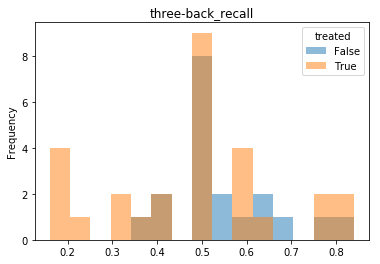

In [154]:
_ = plot_hist(d, 'three-back_recall')

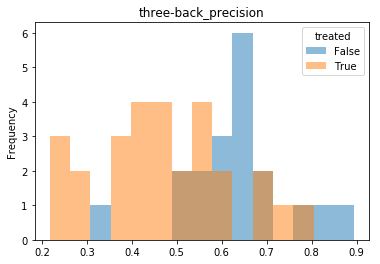

In [155]:
_ = plot_hist(d, 'three-back_precision')

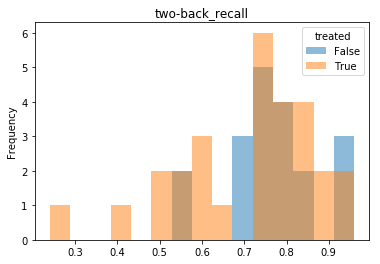

In [156]:
_ = plot_hist(d, 'two-back_recall')

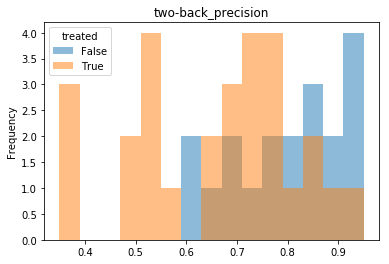

In [157]:
_ = plot_hist(d, 'two-back_precision')

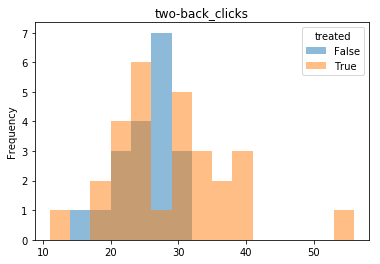

In [158]:
_ = plot_hist(d, 'two-back_clicks')

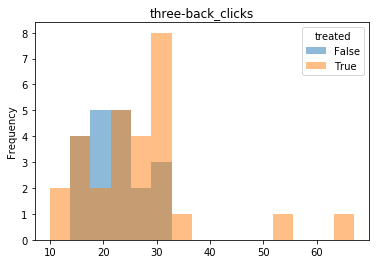

In [159]:
_ = plot_hist(d, 'three-back_clicks')